In [ ]:
"""
Created on 20190504

Inspired by:
1. https://towardsdatascience.com/why-automated-feature-engineering-will-change-the-way-you-do-machine-learning-5c15bf188b96?fbclid=IwAR1JvwK-wsJEQQ1k5gGPvjzj4rkLCwSqut9V0smclJpb-GlwFyZmv-d__eU

Ref:
1. https://github.com/Featuretools/Automated-Manual-Comparison/tree/master/Loan%20Repayment/notebooks
2. DFS: https://blog.featurelabs.com/deep-feature-synthesis/
Topic: Automated Feature Engineering
"""


In [2]:
import featuretools as ft

# Predicting Retail Spending with Automated Feature Engineering in Featuretools
- In this notebook, we will implement an automated feature engineering solution with Featuretools for a set of online retail purchases. The dataset (available from the UCI machine learning repository) is a series of time-stamped purchases and does not come with any labels, so we'll have to make our own prediction problem. After defining the problem, we can use automated feature engineering to build a set of features that are used for training a predictive model.

- This set of retail spending data is great practice both for defining our own prediction problem (known as prediction engineering), and for using some of the time-based capabilities of Featuretools, notably cutoff times. Whenever we have time-series data, we need to be extra careful to not "leak labels" or use information from the future to predict a past event. Usually, when we're doing manual feature engineering, this can be an issue and often, a system will work well in development but utterly fail when deployed because it was trained on invalid data. Fortunately, Featuretools will take care of the time issue for us, creating a rich set of features that obey the time restrictions.
# Roadmap
Following is an outline for this notebook:

    1.Read in data, inspect, and clean
    2. Develop a prediction problem
     - Create a dataframe of labels - what we want to predict, and cutoff times - the point that all data must come before for predicting a label
    3. Create an entityset and add entities
     - Normalize the original table to develop new tables
     - These new tables can be used for making features
    4. Run deep feature sythesis on the entityset to make features
     - Use the cutoff times to make features using valid data for each label
    5. Use the features to train a machine learning model
     - Measure performance of the model relative to an informed baseline
    6. Tune deep feature synthesis
     - Specify custom primitives
     - Adjust maximum depth of features
     - Re-evaluate model
- This problem is a great display of both the time and feature-creation capabilities of Featuretools. Also, we'll be able to use custom primitives to expand on our domain knowledge. Doing this problem by hand and ensuring we use only valid data for each label is a daunting task (as can be seen in the Manual Retail Spending notebook)!

In [3]:
# Data manipulation
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%matplotlib inline

# Automated feature engineering
import featuretools as ft

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

## Load in Raw Data
- The raw data is a collection of purchases from an online retailer collected in 2010-2011. Each row in the original data represents one product that was purchased with multiple purchases forming an order. There are a few issues with the data that will need to be addressed (as with most real-world datasets)!

- This code loads in the data from an s3 bucket, converts the price in Pounds to dollars (based on the exchange rate on May 31, 2011), subsets the data to 2011, and creates a column representing the total of the purchase. The original data description can be found on the UCI Machine Learning Repository.

In [49]:
csv_s3 = "Online Retail.xlsx"
data = pd.read_excel(csv_s3, parse_dates=["InvoiceDate"])

# Convert to dollars
data['UnitPrice'] = data['UnitPrice'] * 1.65
data['Total'] = data['UnitPrice'] * data['Quantity']

# Restrict data to 2011
data = data[data['InvoiceDate'].dt.year == 2011]

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,3.2175,13313.0,United Kingdom,32.175
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,3.4650,13313.0,United Kingdom,17.325
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,2.0625,13313.0,United Kingdom,20.625


In [50]:
# rename to match the example
data.columns  = ["order_id", 'product_id', 'description', 'quantity', 'order_date', 'price',
                'customer_id', 'country', 'total']

In [51]:
data2 = data.copy()

## Data Cleaning
There are a few issues we need to address with the data. First, we'll drop the duplicated rows, then we'll drop any rows that contain a nan. Finally, we can add a Boolean column indicating whether or not an order is a cancellation.

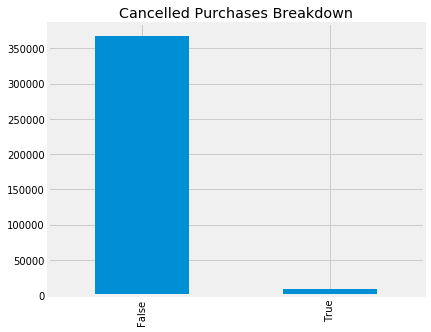

In [55]:
# drop the duplicates
data = data.drop_duplicates()

# drop rows with null customer id
data = data.dropna(axis=0)

data['cancelled'] = data['order_id'].str[:1] == "C"
data['cancelled'].value_counts().plot.bar(figsize = (6, 5));
plt.title('Cancelled Purchases Breakdown');

- All of the cancelled orders have negative quantities which mean that they cancel out with the corresponding purchase. We'll leave in the cancelled purchases, because if our goal (defined later in the prediction problem) is to predict the total amount purchased by a customer, we'll need to take into account their cancelled orders.

In [56]:
data.describe()

,quantity,price,customer_id,total
count,375250.000000,375250.000000,375250.000000,375250.000000
mean,12.252296,5.762031,15265.136168,33.972397
std,258.180877,119.054102,1710.927381,733.803756
min,-80995.000000,0.000000,12346.000000,-277974.840000
25%,2.000000,2.062500,13901.000000,7.012500
50%,5.000000,3.217500,15108.000000,19.305000
75%,12.000000,6.187500,16767.000000,32.670000
max,80995.000000,64300.500000,18287.000000,277974.840000


We can see that most total purchase prices are less than \$50 (this is for a one item). The negative numbers represent cancelled orders. We can plot the purchase total by country (limited to only positive amounts and less than \$1000) to see if there are differences between countries.

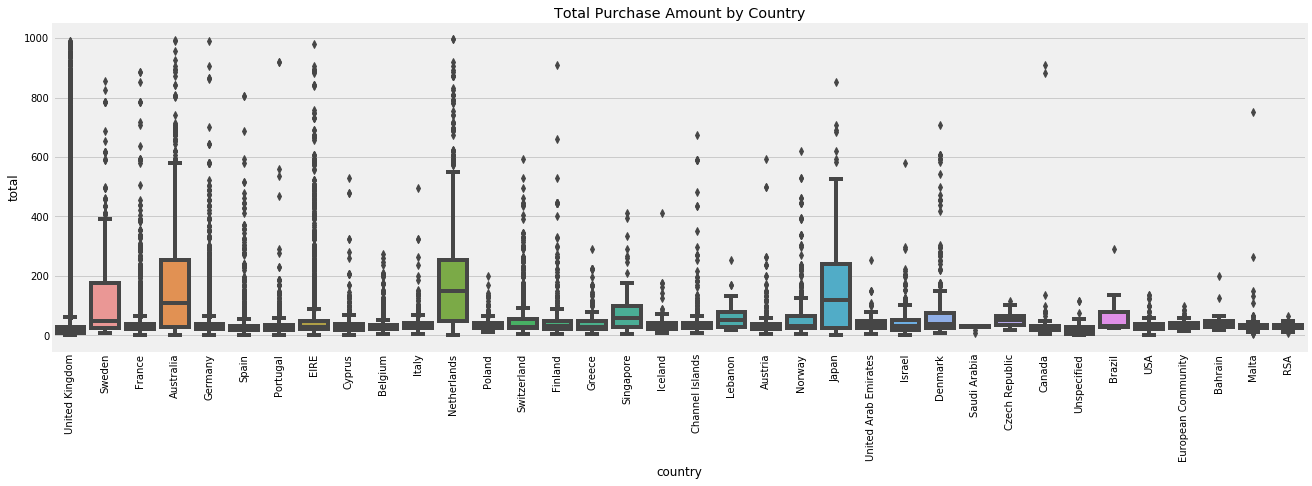

In [57]:
plt.figure(figsize = (20, 6))
sns.boxplot(x = 'country', y = 'total', data = data[(data['total'] > 0) & (data['total'] < 1000)]);
plt.title("Total Purchase Amount by Country");
plt.xticks(rotation = 90);

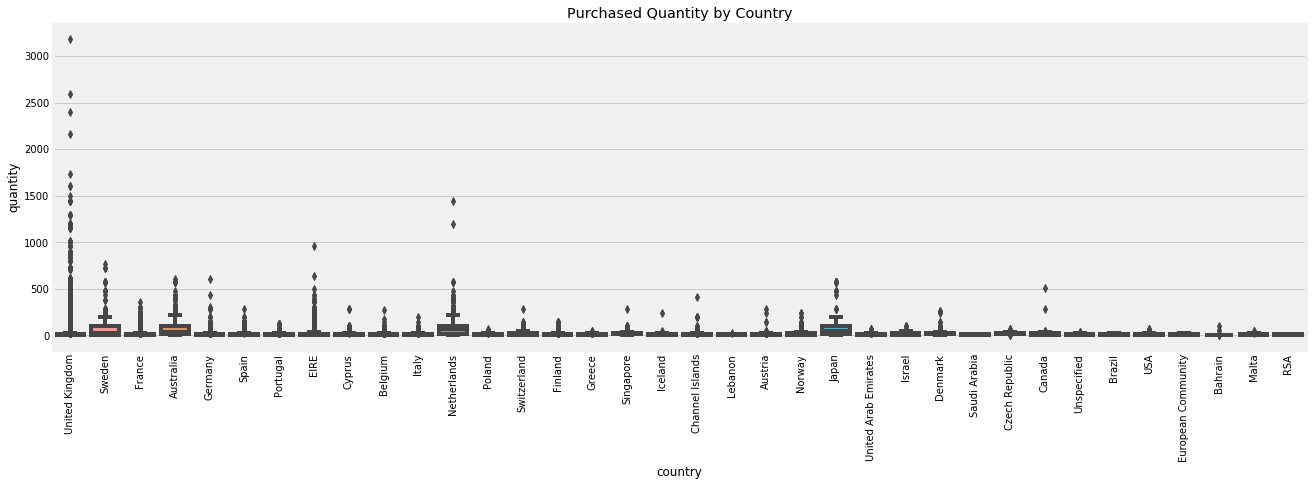

In [58]:
plt.figure(figsize = (20, 6))
sns.boxplot(x = 'country', y = 'quantity', data = data[(data['total'] > 0) & (data['total'] < 1000)]);
plt.title("Purchased Quantity by Country");
plt.xticks(rotation = 90);

- Both the purchase total and the quantity are heavily skewed. This occurs often in real-world data and means this might be difficult as a regression problem (predict the actual spending amount). We might want to frame the problem as classification because the large purchase totals could throw off a machine learning algorithm. Our other option would be to remove the outliers, but given that these are probably legitimate, that does not seem like a responsible choice!

## Skewness of Data

In [59]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

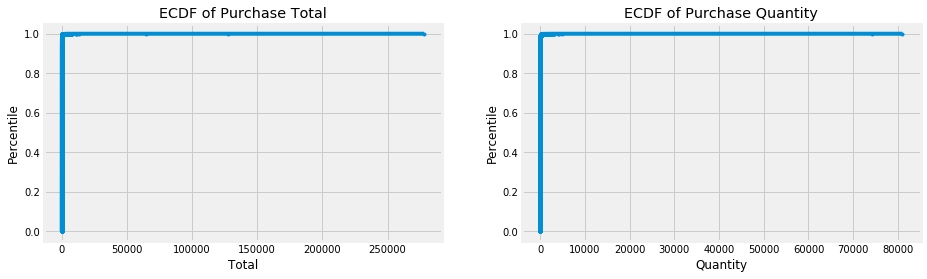

In [60]:
plt.figure(figsize = (14, 4))

# Total
plt.subplot(121)
x, y = ecdf(data.loc[data['total'] > 0, 'total'])
plt.plot(x, y, marker = '.')
plt.xlabel('Total'); plt.ylabel('Percentile'); plt.title('ECDF of Purchase Total');

# Quantity
plt.subplot(122)
x, y = ecdf(data.loc[data['total'] > 0, 'quantity'])
plt.plot(x, y, marker = '.')
plt.xlabel('Quantity'); plt.ylabel('Percentile'); plt.title('ECDF of Purchase Quantity');

The majority of total purchases are less than \$20, but there a number of outliers. Rather than using a regression problem, we therefore might want to try classifying customers based on their spending per month.

## Prediction Problem
- The goal of machine learning is to predict some quantity (regression) or a label (classification). Our data exploration showed that regression might not be the best approach because of the extreme outliers, so instead we can make the problem classification.

- With this dataset, there are an unlimited number of prediction problems because there are no labels (unlike in many machine learning competitions). Choosing a worthwhile quantity to predict therefore becomes critical. In most real-world situations, we could use a domain expert to frame a problem based on what they know is important in the field, and then it's our objective to make a set of labels and features based on that problem. This is known as prediction engineering.

- We'll frame the problem as predicting whether or not a customer will spend more than \$500 in the next month. This could be useful to a business because it will let them market more effectively to those customers who are likely to spend more. Moreover, an online retailer could advertise differently to customers based on their predicted class of spending.

- Instead of picking just a single month for predictions, we can use each customer as a label multiple times. In other words, we not only predict whether a given customer will spend more than \$500 in May, but we also ask the same question in June, July, and so on. The thing to note is that for each month, we can't use data from the future to predict the class of spending. Each month we can use information from any previous month which means that our predictions should get more accurate as we advance further in time through the data since we'll be able to use more information. Each label for a customer therefore has a different set of features because there is more or less data available to us depending on the month. Doing this by hand is very tedious and error-prone, but we'll see how Featuretools is able to handle the times associated with each label using cutoff times.

## Making Labels
- The function below takes in a start date and an end date (which we set to 30 days apart) and generates a dataframe of the labels, which depends on how much the customer spent in the period and the threshold. Our threshold will be \$500 for this prediction problem.

- For customers who appear in the data prior to the start date but then do not have a purchase in between the start and end date, we set their total to 0. If we simply did not include them in the labels, then that would be cheating since we have no way of knowing ahead of time that they will not spend anything in the next month.

In [67]:
def make_retail_cutoffs_total(start_date, end_date, threshold = 500):
    
    # Find customers who exist before start date
    customer_pool = data[data['order_date'] < start_date]['customer_id'].unique()
    tmp = pd.DataFrame({'customer_id': customer_pool})

    # For customers in the customer pool, find their sum between the start and end date
    totals = data[data['customer_id'].isin(customer_pool) & 
        (data['order_date'] > start_date) & 
        (data['order_date']<end_date)
    ].groupby('customer_id')['total'].sum().reset_index()
    
    # Merge with all the customer ids to record all customers who existed before start date
    totals = totals.merge(tmp, on = 'customer_id', how = 'right')

    # Set the total for any customer who did not have a purchase in the timeframe equal to 0
    totals['total'] = totals['total'].fillna(0)
    
    # Label is based on the threshold
    totals['label'] = (totals['total'] > threshold).astype(int)
        
    # The cutoff time is the start date
    totals['cutoff_time'] = pd.to_datetime(start_date)
    totals = totals[['customer_id', 'cutoff_time', 'total', 'label']]
    
    return totals

In [68]:
may_spending = make_retail_cutoffs_total(pd.datetime(2011, 5, 1), pd.datetime(2011, 6, 1))
may_spending.head()

,customer_id,cutoff_time,total,label
0,12372.0,2011-05-01,850.9050,1
1,12395.0,2011-05-01,547.4535,1
2,12399.0,2011-05-01,793.4850,1
3,12414.0,2011-05-01,273.6525,0
4,12415.0,2011-05-01,20940.4140,1



For each customer who appeared in the data before May, we have a label for them for the month of May which is the sum of their spending in May converted to a binary label. When we make features for these labels, we can only use data from before May. The cutoff_time represents the point at which any data we use must come before and the label is based on our threshold of \$500.

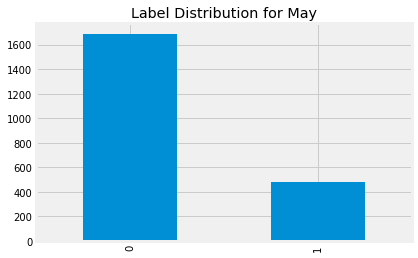

In [69]:
may_spending['label'].value_counts().plot.bar();
plt.title('Label Distribution for May');

## Metrics

Instead of accuracy, we can measure performance in terms of:

1.Precision: the percentage of customers predicted to spend more than \$500 that actually did
2. Recall: the percentage of customers that actually spent more than \$500 that were correctly identified
3. F1 score: the harmonic mean of precision and recall
4. Receiver Operating Characterisic Area Under the Curve (ROC AUC): a 0 to 1 measure (with 1 being optimal) that measures the performance of a model across a range of thresholds
We'll have to establish a baseline for these metrics (which will be a little later) so we know whether machine learning is useful for this task.

Next we'll go ahead and make labels for the rest of the year. Keep in mind that this will generate one label for each customer for each month. We're used to thinking of a single label per customer, but since we have the data, we might as well use each customer as a training example as many times as possible (as long as we use valid data each time). A greater number of training observations should increase the predictive power of our model.

In [70]:
march_spending = make_retail_cutoffs_total('2011-03-01', '2011-04-01', 500)
april_spending = make_retail_cutoffs_total('2011-04-01', '2011-05-01', 500)
june_spending = make_retail_cutoffs_total('2011-06-01', '2011-07-01', 500)
july_spending = make_retail_cutoffs_total('2011-07-01', '2011-08-01', 500)
august_spending = make_retail_cutoffs_total('2011-08-01', '2011-09-01', 500)
september_spending = make_retail_cutoffs_total('2011-09-01', '2011-10-01', 500)
october_spending = make_retail_cutoffs_total('2011-10-01', '2011-11-01', 500)
november_spending = make_retail_cutoffs_total('2011-11-01', '2011-12-01', 500)
december_spending = make_retail_cutoffs_total('2011-12-01', '2012-01-01', 500)

In [73]:
labels = pd.concat([march_spending, april_spending, may_spending, june_spending, july_spending, august_spending, 
                    september_spending, october_spending, november_spending, december_spending], axis = 0)
labels.to_csv('./labels.csv')
labels.describe()

,customer_id,total,label
count,28133.000000,28133.000000,28133.000000
mean,15268.704155,326.503391,0.170547
std,1722.948845,1870.433936,0.376119
min,12346.000000,-5916.636000,0.000000
25%,13777.000000,0.000000,0.000000
50%,15235.000000,0.000000,0.000000
75%,16755.000000,196.020000,0.000000
max,18287.000000,115906.725000,1.000000


- We have roughly 28,000 labels with ~17% of them positive. The total is very skewed, with several customers recording negative total for some months (they had more cancellations than purchases). By framing this as a classification problem, we don't have to worry about the outlying purchase totals throwing off our model.

- Just to examine the data, we can plot the total spending distribution by month (with negative totals removed)

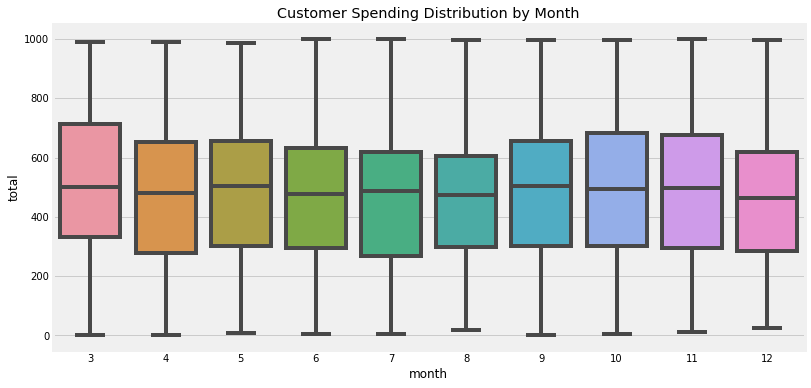

In [74]:
plot_labels = labels.copy()
plot_labels['month'] = plot_labels['cutoff_time'].dt.month

plt.figure(figsize = (12, 6))
sns.boxplot(x = 'month', y = 'total', 
            data = plot_labels[(plot_labels['total'] > 0) & (plot_labels['total'] < 1000)]);
plt.title('Customer Spending Distribution by Month');

In [75]:
labels.loc[labels['customer_id'] == 12347]

,customer_id,cutoff_time,total,label
845,12347.0,2011-03-01,0.0000,0
0,12347.0,2011-04-01,1049.8125,1
1111,12347.0,2011-05-01,0.0000,0
0,12347.0,2011-06-01,631.1580,1
1165,12347.0,2011-07-01,0.0000,0
0,12347.0,2011-08-01,965.1015,1
1357,12347.0,2011-09-01,0.0000,0
0,12347.0,2011-10-01,2135.6280,1
1658,12347.0,2011-11-01,0.0000,0
0,12347.0,2011-12-01,370.9530,0


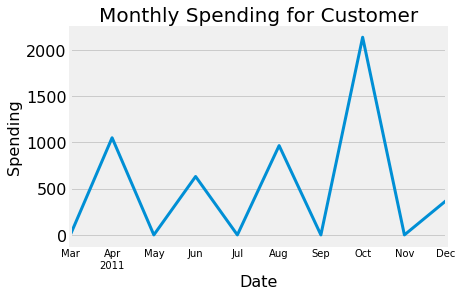

In [76]:
labels.loc[labels['customer_id'] == 12347].set_index('cutoff_time')['total'].plot(figsize = (6, 4), linewidth = 3)
plt.xlabel('Date', size = 16); 
plt.ylabel('Spending', size = 16); 
plt.title('Monthly Spending for Customer', size = 20);
plt.xticks(size = 16); plt.yticks(size = 16);

- One customer, 8 different labels. It seems like it might be difficult to predict this customer's spending given her fluctuating total spending! We'll have to see if Featuretools is up to the task.

- We now have our prediction problem all set. The next step is to start making features we can use in a machine learning model.

## Featuretools Implementation
- The first step in Featuretools is to create an *EntitySet* which will hold all of our data and the relationships between the multiple tables (which we'll create shortly). Initially we'll add the entire data as an entity to the set. Since data has a time_index, we'll add that and specify the variable type of the product description.

- The time_index represents the first time the information in that row is known. When we build features, Featuretools will use this time_index to filter data based on the cutoff time of the label. We can't use any purchases from after the cutoff time of the label to make features for that label

In [79]:
es = ft.EntitySet(id="Online Retail Logs")

# Add the entire data table as an entity
es.entity_from_dataframe("purchases",
                         dataframe=data,
                         index="purchases_index",
                         time_index = 'order_date',
                         variable_types = {'description': ft.variable_types.Text})

es['purchases']

TypeError: invalid string coercion to datetime

featuretools.variable_types.variable.Text